In [1]:
import os
import warnings

warnings.simplefilter("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:

from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from check_shapes import inherit_check_shapes

import gpflow as gf
from gpflow.ci_utils import reduce_in_tests
from gpflow.utilities import print_summary

%matplotlib inline

gf.config.set_default_summary_fmt("notebook")

optimizer_config = dict(maxiter=reduce_in_tests(1000))
n_data = reduce_in_tests(300)
X_plot = np.linspace(0.0, 1.0, reduce_in_tests(101))[:, None]

In [3]:
n_data = reduce_in_tests(20)
n_repeats = reduce_in_tests(10)


def generate_empiricial_noise_data() -> Tuple[
    gf.base.AnyNDArray, gf.base.AnyNDArray
]:
    rng = np.random.default_rng(42)  # for reproducibility
    X = rng.uniform(0.0, 1.0, (n_data, 1))
    signal = np.sin(6 * X)
    noise_scale = rng.uniform(0.1, 1.0, (n_data, 1))
    noise = noise_scale * rng.standard_normal((n_data, n_repeats))
    Y = signal + noise
    return X, Y


X, Y = generate_empiricial_noise_data()
Y_mean = np.mean(Y, axis=-1, keepdims=True)
Y_var = np.var(Y, axis=-1, keepdims=True)

In [4]:
Y_mean = np.mean(Y, axis=-1, keepdims=True)

In [6]:
model = gf.models.GPR(
    data=(X, Y_mean),
    kernel=gf.kernels.SquaredExponential(),
)
gf.optimizers.Scipy().minimize(
    model.training_loss, model.trainable_variables, options=optimizer_config
)
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.5174
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.24234
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.02477


In [7]:
def plot_distribution(
    X: gf.base.AnyNDArray,
    Y: gf.base.AnyNDArray,
    X_plot: Optional[gf.base.AnyNDArray] = None,
    mean_plot: Optional[gf.base.AnyNDArray] = None,
    var_plot: Optional[gf.base.AnyNDArray] = None,
    X_err: Optional[gf.base.AnyNDArray] = None,
    mean_err: Optional[gf.base.AnyNDArray] = None,
    var_err: Optional[gf.base.AnyNDArray] = None,
) -> None:
    plt.figure(figsize=(15, 5))

    X = X.squeeze(axis=-1)
    Y = Y.squeeze(axis=-1)
    plt.scatter(X, Y, color="gray", alpha=0.8)

    def get_confidence_bounds(
        mean: gf.base.AnyNDArray, var: gf.base.AnyNDArray
    ) -> Tuple[gf.base.AnyNDArray, gf.base.AnyNDArray]:
        std = np.sqrt(var)
        return mean - 1.96 * std, mean + 1.96 * std

    if X_plot is not None:
        assert mean_plot is not None
        assert var_plot is not None
        X_plot = X_plot.squeeze(axis=-1)
        mean_plot = mean_plot.squeeze(axis=-1)
        var_plot = var_plot.squeeze(axis=-1)
        lower_plot, upper_plot = get_confidence_bounds(mean_plot, var_plot)
        plt.fill_between(
            X_plot, lower_plot, upper_plot, color="silver", alpha=0.25
        )
        plt.plot(X_plot, lower_plot, color="silver")
        plt.plot(X_plot, upper_plot, color="silver")
        plt.plot(X_plot, mean_plot, color="black")

    if X_err is not None:
        assert mean_err is not None
        assert var_err is not None
        lower_err, upper_err = get_confidence_bounds(mean_err, var_err)
        plt.vlines(X_err, lower_err, upper_err, color="black")

    plt.xlim([0, 1])
    plt.show()


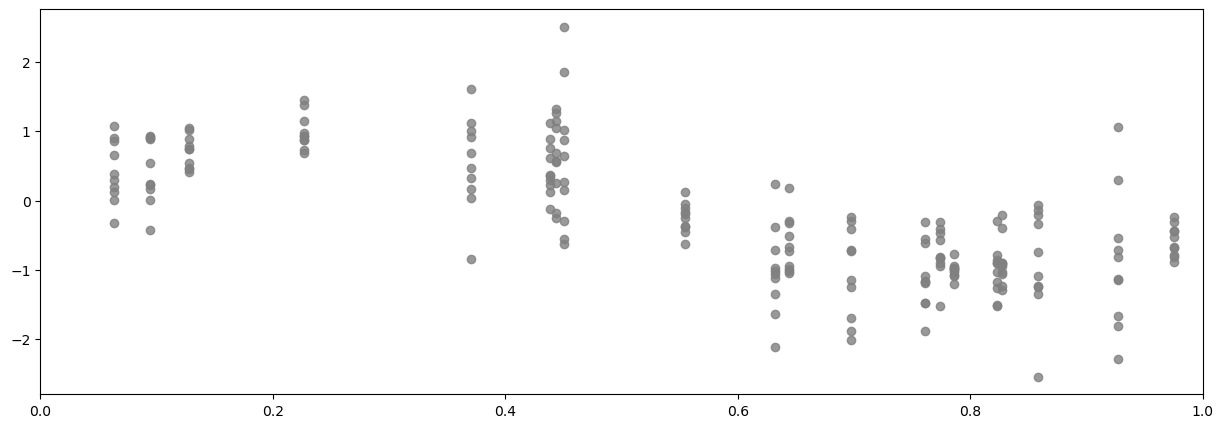

In [9]:

X_flat = np.broadcast_to(X, Y.shape).reshape((-1, 1))
Y_flat = Y.reshape((-1, 1))
plot_distribution(X_flat, Y_flat)

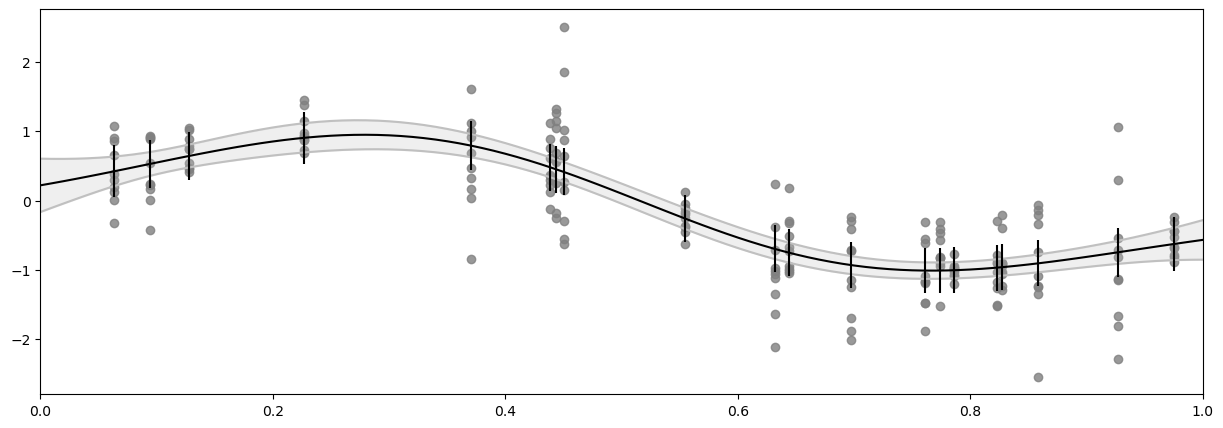

In [10]:
f_mean, f_var = model.predict_f(X_plot)
y_mean_mean, y_mean_var = model.predict_y(X)

plot_distribution(
    X_flat,
    Y_flat,
    X_plot,
    f_mean.numpy(),
    f_var.numpy(),
    X,
    y_mean_mean.numpy(),
    y_mean_var.numpy(),
)

In [11]:
class FixedVarianceOfMean(gf.functions.Function):
    def __init__(self, Y: gf.base.AnyNDArray):
        n_repeats = Y.shape[-1]
        self.var_mean = np.var(Y, axis=-1, keepdims=True) / n_repeats

    @inherit_check_shapes
    def __call__(self, X: gf.base.TensorType) -> tf.Tensor:
        return self.var_mean

In [12]:
model = gf.models.GPR(
    data=(X, Y_mean),
    kernel=gf.kernels.SquaredExponential(active_dims=[0]),
    likelihood=gf.likelihoods.Gaussian(variance=FixedVarianceOfMean(Y)),
)
gf.optimizers.Scipy().minimize(
    model.training_loss, model.trainable_variables, options=optimizer_config
)
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.60614
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.26903


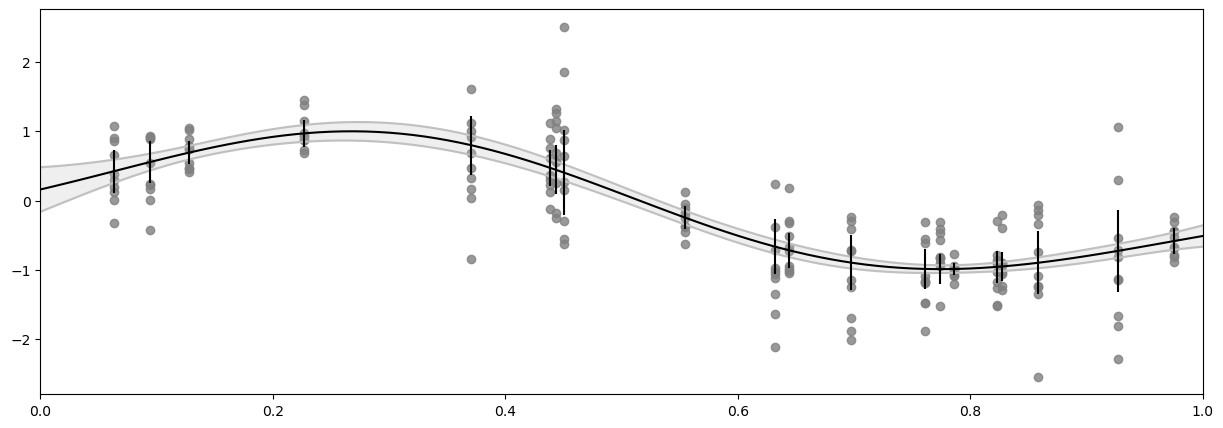

In [13]:

f_mean, f_var = model.predict_f(X_plot)
y_mean_mean, y_mean_var = model.predict_y(X)

plot_distribution(
    X_flat,
    Y_flat,
    X_plot,
    f_mean.numpy(),
    f_var.numpy(),
    X,
    y_mean_mean.numpy(),
    y_mean_var.numpy(),
)

## Second notebook

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import gpflow as gpf

In [16]:
N = 1001

np.random.seed(0)
tf.random.set_seed(0)

# Build inputs X
X = np.linspace(0, 4 * np.pi, N)[:, None]  # X must be of shape [N, 1]

# Deterministic functions in place of latent ones
f1 = np.sin
f2 = np.cos

# Use transform = exp to ensure positive-only scale values
transform = np.exp

# Compute loc and scale as functions of input X
loc = f1(X)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

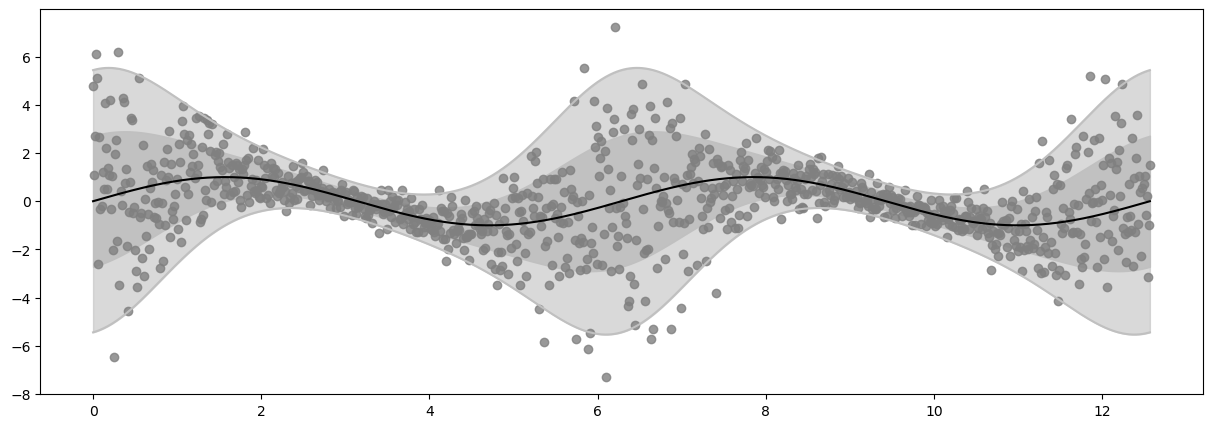

In [17]:

def plot_distribution(X, Y, loc, scale):
    plt.figure(figsize=(15, 5))
    x = X.squeeze()
    for k in (1, 2):
        lb = (loc - k * scale).squeeze()
        ub = (loc + k * scale).squeeze()
        plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
    plt.plot(x, lb, color="silver")
    plt.plot(x, ub, color="silver")
    plt.plot(X, loc, color="black")
    plt.scatter(X, Y, color="gray", alpha=0.8)
    plt.show()
    plt.close()


plot_distribution(X, Y, loc, scale)

In [18]:
likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")

Likelihood's expected latent_dim: 2


In [19]:
kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpf.kernels.SquaredExponential(),  # this is k2, the kernel of f2
    ]
)
# The number of kernels contained in gpf.kernels.SeparateIndependent must be the same as likelihood.latent_dim

In [20]:
M = 20  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(X.min(), X.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)

In [21]:
model = gpf.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)

model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(20, 1)",float64,[[0....
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(20, 1)",float64,[[0....
SVGP.q_mu,Parameter,Identity,,True,"(20, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 20, 20)",float64,"[[[1., 0., 0...."


In [23]:
data = (X, Y)
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

In [24]:
epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")

Instructions for updating:
Use fn_output_signature instead
Epoch 20 - Loss:  1471.8678
Epoch 40 - Loss:  1452.4426
Epoch 60 - Loss:  1450.7381
Epoch 80 - Loss:  1450.0566
Epoch 100 - Loss:  1449.6072


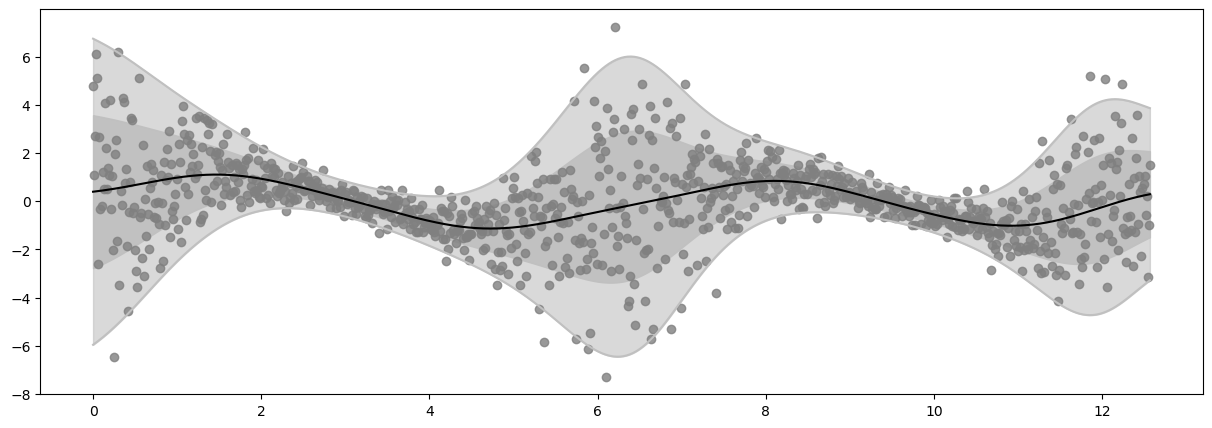

In [25]:
        Ymean, Yvar = model.predict_y(X)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(X, Y, Ymean, Ystd)